In [42]:
import numpy as np
import tensorflow as tf

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

# dataset_path = os.listdir('datasets')

# print (dataset_path)  #what kinds of classes are in this dataset

# print("Types of classes labels found: ", len(dataset_path))
dataset_dir = "datasets"
sub_dirs = ["train", "valid", "test"]
class_labels = []

# Iterate through each dataset split (train, valid, test)
for sub_dir in sub_dirs:
    sub_path = os.path.join(dataset_dir, sub_dir)
    
    for class_name in os.listdir(sub_path):  # List class folders
        class_dir = os.path.join(sub_path, class_name)
        
        # Skip non-directory files (.DS_Store)
        if not os.path.isdir(class_dir):
            continue
        
        # Get all image file names inside each class folder
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            class_labels.append((class_name, image_path))

# Build DataFrame
df = pd.DataFrame(data=class_labels, columns=['Labels', 'Image'])

# Display first and last few rows
print(df.head())
print(df.tail())

                  Labels                                              Image
0  Potato___Early_blight  datasets/train/Potato___Early_blight/bc7552e4-...
1  Potato___Early_blight  datasets/train/Potato___Early_blight/d8a8d6e5-...
2  Potato___Early_blight  datasets/train/Potato___Early_blight/d84ba2ee-...
3  Potato___Early_blight  datasets/train/Potato___Early_blight/f164ce92-...
4  Potato___Early_blight  datasets/train/Potato___Early_blight/faac446b-...
                Labels                                              Image
1495  Potato___healthy  datasets/test/Potato___healthy/Potato_healthy-...
1496  Potato___healthy  datasets/test/Potato___healthy/Potato_healthy-...
1497  Potato___healthy  datasets/test/Potato___healthy/Potato_healthy-...
1498  Potato___healthy  datasets/test/Potato___healthy/Potato_healthy-...
1499  Potato___healthy  datasets/test/Potato___healthy/Potato_healthy-...


In [44]:
len(df)

1500

In [46]:
import os
import cv2
import numpy as np

# Define dataset directories
dataset_dir = "datasets"
sub_dirs = ["Train", "Valid", "Test"]  # Make sure these match your actual folder names

im_size = 224
images = []
labels = []

# Loop through train, valid, test folders
for sub_dir in sub_dirs:
    sub_path = os.path.join(dataset_dir, sub_dir)

    for class_name in os.listdir(sub_path):
        class_path = os.path.join(sub_path, class_name)

        if not os.path.isdir(class_path):  # Skip .DS_Store and other non-folder files
            continue

        for img_file in os.listdir(class_path):  # Now accessing actual images
            img_path = os.path.join(class_path, img_file)

            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):  
                print(f"Skipping non-image file: {img_path}")
                continue  # Skip non-image files

            img = cv2.imread(img_path)
            
            if img is None:
                print(f"Skipping corrupted image: {img_path}")
                continue  
            
            img = cv2.resize(img, (im_size, im_size))
            images.append(img)
            labels.append(class_name)

# Convert images list to NumPy array
images = np.array(images)

print(f"Total images loaded: {len(images)}")
print(f"Total labels loaded: {len(labels)}")


Total images loaded: 1500
Total labels loaded: 1500


In [48]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

y = df['Labels'].values
print(y)

y_labelencoder = LabelEncoder()
y = y_labelencoder.fit_transform(y)
print(y)


['Potato___Early_blight' 'Potato___Early_blight' 'Potato___Early_blight'
 ... 'Potato___healthy' 'Potato___healthy' 'Potato___healthy']
[0 0 0 ... 2 2 2]


In [50]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

y = df['Labels'].values
print(y)

# Label Encoding
y_labelencoder = LabelEncoder()
y = y_labelencoder.fit_transform(y)

# Reshape for ColumnTransformer
y = y.reshape(-1, 1)

# One-Hot Encoding
ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
Y = ct.fit_transform(y)

print(Y[:5])  # First 5 encoded labels
print(Y[35:])  # Labels from index 35 onwards


['Potato___Early_blight' 'Potato___Early_blight' 'Potato___Early_blight'
 ... 'Potato___healthy' 'Potato___healthy' 'Potato___healthy']
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [52]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

images, Y = shuffle(images, Y, random_state=1)

train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.20, random_state=415)

# Inspect the shape of training and testing sets
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


(1200, 224, 224, 3)
(1200, 3)
(300, 224, 224, 3)
(300, 3)


In [54]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping

NUM_CLASSES = 3
IMG_SIZE = 224
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Use pre-trained EfficientNetB0 without top layers
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=inputs)
x = layers.GlobalAveragePooling2D()(base_model.output)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = model.fit(train_x, train_y, epochs=30, batch_size=64, validation_data=(test_x, test_y), validation_freq=5, callbacks=[early_stop], verbose=2)


Epoch 1/30


KeyboardInterrupt: 

In [56]:
hist = model.fit(train_x, train_y, epochs=3, batch_size=32, validation_data=(test_x, test_y), verbose=2)


Epoch 1/3


KeyboardInterrupt: 

In [190]:
model.save("plant_disease_model.h5")


In [26]:

def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to model input size
    img = img.astype("float32") / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get the class index

    print(f"Predicted Class: {predicted_class}")

predict_image("Test_pics/lblight5.jpg")
class_mapping = dict(enumerate(y_labelencoder.classes_))
print(class_mapping)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Class: 1
{0: 'Potato___Early_blight', 1: 'Potato___Late_blight', 2: 'Potato___healthy'}


Input image shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Class: Late Blight


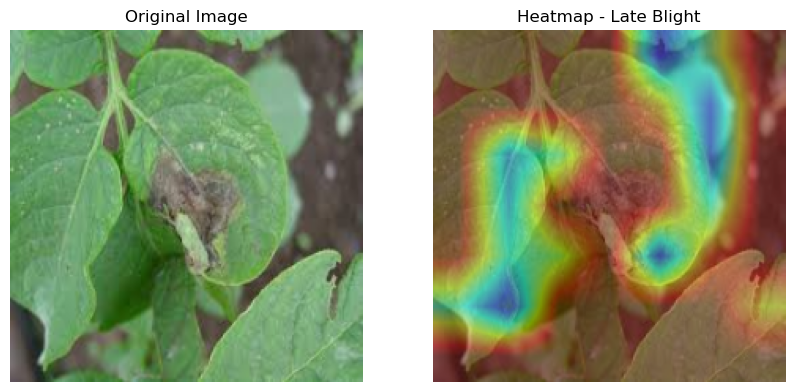

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Model

# Load image using OpenCV
img_path = 'Test_pics/lblight3.jpeg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
img = cv2.resize(img, (224, 224))  # Resize to match model input

# Preprocess image for model prediction
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)

print('Input image shape:', x.shape)

class_labels = ["Early Blight", "Late Blight", "Healthy"]

# Get model prediction
predictions = model.predict(x)  # `x` is your preprocessed input image
predicted_index = np.argmax(predictions)
predicted_class = class_labels[predicted_index]
predictions

print("Predicted Class:", predicted_class)

# ========== GRAD-CAM HEATMAP ==========
last_conv_layer = model.get_layer("top_conv") 

grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    loss = predictions[:, predicted_index]

grads = tape.gradient(loss, conv_outputs)

grads = tf.reduce_mean(grads, axis=(0, 1, 2))

heatmap = np.mean(conv_outputs.numpy(), axis=-1).squeeze()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (224, 224))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title(f"Heatmap - {predicted_class}")
plt.axis("off")

plt.show()


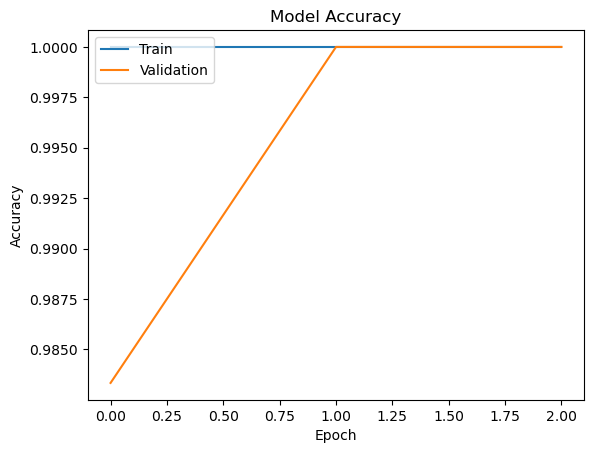

In [214]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"]) 
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()

plot_hist(hist)


In [66]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# ===================== Load Dataset =====================
dataset_path = "Potato_Dataset"
img_size = 224
images = []
labels = []

for label in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, label)
    if not os.path.isdir(class_dir):
        continue
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                images.append(img)
                labels.append(label)

print(f"Total Images Loaded: {len(images)}")
print(f"Unique Labels: {set(labels)}")

Total Images Loaded: 5748
Unique Labels: {'earlyblight', 'pest', 'lateblight', 'fungi', 'virus', 'healthy'}


In [68]:
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_encoded = labels_encoded.reshape(-1, 1)
onehot = OneHotEncoder()
labels_onehot = onehot.fit_transform(labels_encoded).toarray()

In [70]:
images = np.array(images).astype("float32") / 255.0
images, labels_onehot = shuffle(images, labels_onehot, random_state=42)

train_x, test_x, train_y, test_y = train_test_split(images, labels_onehot, test_size=0.2, random_state=42)

In [72]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

num_classes = labels_onehot.shape[1]
inputs = layers.Input(shape=(img_size, img_size, 3))
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_x, train_y, epochs=3, batch_size=32,
                    validation_data=(test_x, test_y),
                    callbacks=[early_stop],
                    verbose=2)


Epoch 1/3
144/144 - 329s - 2s/step - accuracy: 0.8325 - loss: 0.4230 - val_accuracy: 0.1739 - val_loss: 3.6462
Epoch 2/3
144/144 - 308s - 2s/step - accuracy: 0.9415 - loss: 0.1664 - val_accuracy: 0.1739 - val_loss: 5.5051
Epoch 3/3
144/144 - 350s - 2s/step - accuracy: 0.9632 - loss: 0.1149 - val_accuracy: 0.1739 - val_loss: 6.6750


In [76]:
model.save("plant_disease_model.h5")
class_mapping = dict(enumerate(le.classes_))
print("Class Mapping:", class_mapping)


Class Mapping: {0: 'earlyblight', 1: 'fungi', 2: 'healthy', 3: 'lateblight', 4: 'pest', 5: 'virus'}


In [78]:
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    predicted_index = np.argmax(prediction)
    predicted_label = le.classes_[predicted_index]
    print(f"Predicted Class: {predicted_label}")

In [80]:
predict_image("Test_pics/The-three-Sample-leaves-of-potato-are-a-leaf-affected-by-Light-Blight-b-leaf.png") 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Predicted Class: healthy


In [34]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_x, test_y, verbose=2)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


36/36 - 11s - 316ms/step - accuracy: 0.1739 - loss: 3.9334
Test Accuracy: 17.39%


In [86]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Enhanced data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    validation_split=0.2  # for validation data
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 4599 images belonging to 7 classes.
Found 1149 images belonging to 7 classes.


Classes: ['lateblight', 'pest', 'healthy', 'fungi', 'virus', 'earlyblight']
Number of classes: 6

Images per class:
lateblight: 1000 images
pest: 1000 images
healthy: 1000 images
fungi: 748 images
virus: 1000 images
earlyblight: 1000 images


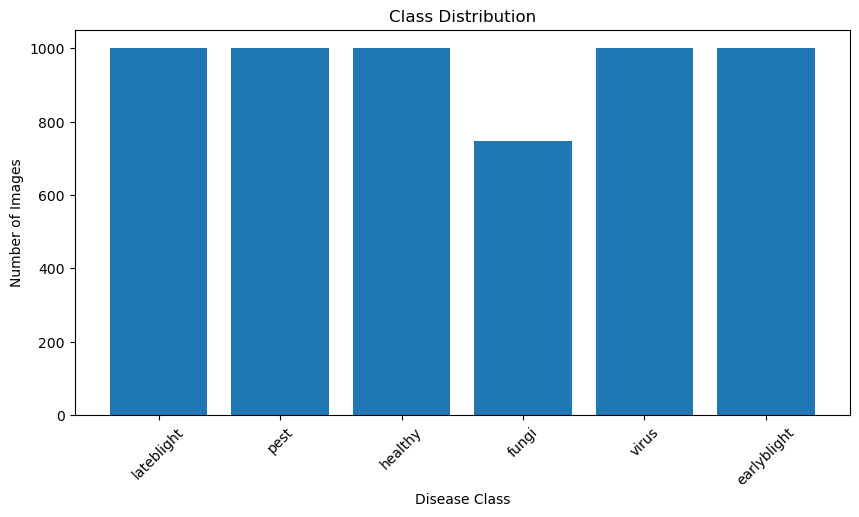

In [102]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30

# Load and explore dataset
dataset_path = 'Potato_Dataset'

# Get only directories (skip files like .DS_Store)
# Exclude any unwanted folders like .ipynb_checkpoints
classes = [d for d in os.listdir(dataset_path) 
           if os.path.isdir(os.path.join(dataset_path, d)) and not d.startswith('.')]

print("Classes:", classes)
print("Number of classes:", len(classes))


# Count images per class (skip non-image files)
class_counts = {}
for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    # Only count files that are images
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[class_name] = len(image_files)
    
print("\nImages per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution")
plt.xlabel("Disease Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

In [104]:
# Load images and labels
images = []
labels = []

for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
            labels.append(class_name)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize pixel values
images = images.astype('float32') / 255.0

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_onehot = tf.keras.utils.to_categorical(labels_encoded, NUM_CLASSES)

# Split into train and test sets
train_x, test_x, train_y, test_y = train_test_split(
    images, labels_onehot, test_size=0.2, random_state=42, stratify=labels_encoded
)

print(f"\nTraining set shape: {train_x.shape}")
print(f"Test set shape: {test_x.shape}")


Training set shape: (4598, 224, 224, 3)
Test set shape: (1150, 224, 224, 3)


In [106]:
# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()  # No augmentation for validation

train_generator = train_datagen.flow(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_generator = test_datagen.flow(
    test_x, test_y,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [114]:
def build_model():
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling='avg'
    )
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model = build_model()
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,710,569 (17.97 MB)

 Trainable params: 659,974 (2.52 MB)

 Non-trainable params: 4,050,595 (15.45 MB)

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers

# Dataset Path
path = 'Potato_Dataset/'
dataset_path = os.listdir(path)
print("Classes:", dataset_path)
print("Number of Classes:", len(dataset_path))

# Build image paths and labels
class_labels = []
for cls in dataset_path:
    cls_path = os.path.join(path, cls)
    if os.path.isdir(cls_path):  # 👈 Skip files like .DS_Store
        for file in os.listdir(cls_path):
            class_labels.append((cls, os.path.join(cls_path, file)))


# Create dataframe
df = pd.DataFrame(class_labels, columns=["Labels", "image"])
print(df.head())
print("Total images:", len(df))

# Load images and labels
im_size = 224
images = []
labels = []

for index, row in df.iterrows():
    img = cv2.imread(row['image'])
    if img is not None:
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        labels.append(row['Labels'])

images = np.array(images).astype('float32') / 255.0
print("Images shape:", images.shape)

# Encode labels
y = df['Labels'].values
label_enc = LabelEncoder()
y_encoded = label_enc.fit_transform(y).reshape(-1, 1)

# One-hot encode with correct keyword for newer scikit-learn versions
ct = ColumnTransformer([('my_ohe', OneHotEncoder(sparse_output=False), [0])], remainder='passthrough')
Y = ct.fit_transform(y_encoded)

# Convert to NumPy array (safe)
Y = np.array(Y)

# Shuffle and split
images, Y = shuffle(images, Y, random_state=42)
train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.05, random_state=42)

print("Train:", train_x.shape, train_y.shape)
print("Test:", test_x.shape, test_y.shape)

# Build EfficientNetB0 model from scratch
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')

# Freeze the base model
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
hist = model.fit(train_x, train_y, epochs=15, batch_size=32, verbose=2)

# Plot training history
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

plot_hist(hist)

# Evaluate the model
loss, acc = model.evaluate(test_x, test_y)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")


Classes: ['lateblight', 'pest', '.DS_Store', 'healthy', '.ipynb_checkpoints', 'fungi', 'virus', 'earlyblight']
Number of Classes: 8
       Labels                                            image
0  lateblight  Potato_Dataset/lateblight/Late_Blight (377).jpg
1  lateblight  Potato_Dataset/lateblight/Late_Blight (727).jpg
2  lateblight  Potato_Dataset/lateblight/Late_Blight (232).JPG
3  lateblight  Potato_Dataset/lateblight/Late_Blight (398).jpg
4  lateblight  Potato_Dataset/lateblight/Late_Blight (662).jpg
Total images: 5748
Images shape: (5748, 224, 224, 3)
Train: (5460, 224, 224, 3) (5460, 6)
Test: (288, 224, 224, 3) (288, 6)


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_33        │ (None, 224, 224,  │          0 │ input_layer_32[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_18    │ (None, 224, 224,  │          7 │ rescaling_33[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_34        │ (None, 224, 224,  │          0 │ normalization_18… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_34[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,379,049 (16.70 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/15
171/171 - 60s - 353ms/step - accuracy: 0.1650 - loss: 1.8079
Epoch 2/15
171/171 - 54s - 316ms/step - accuracy: 0.1701 - loss: 1.7894
Epoch 3/15
171/171 - 53s - 309ms/step - accuracy: 0.1656 - loss: 1.7880
Epoch 4/15
